In [1]:
!nvidia-smi

Thu Aug 14 10:30:21 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090      WDDM  |   00000000:1C:00.0  On |                  Off |
| 30%   88C    P2            314W /  450W |   23346MiB /  24564MiB |     90%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Libraries
import pandas as pd
import numpy as np
import re

import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AutoModelForSequenceClassification

# Hugging Face Dataset
from datasets import Dataset, load_dataset, concatenate_datasets
import evaluate

from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.metrics import cohen_kappa_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from scipy.stats import pearsonr

import seaborn as sns
import matplotlib.pyplot as plt

### Model Inference on Test Essays

In [3]:
# Load the fine-tuned BERT model 
tokenizer = AutoTokenizer.from_pretrained("./bert_base_cased_per_AES_746")
model = AutoModelForSequenceClassification.from_pretrained("./bert_base_cased_per_AES_746")

In [4]:
# read in the test data 
test_pred_pd = pd.read_csv(r'.\ellipse_test_pred.csv')
print(cohen_kappa_score(test_pred_pd['predicted_label'], test_pred_pd['label'], weights='quadratic'))

0.7010157768210825


In [5]:
test_pred_pd.head()

,text_id_kaggle,full_text,Overall,Cohesion,Syntax,Vocabulary,Phraseology,Grammar,Conventions,label,predicted_score,predicted_label
0,EAE70CCAFC13,"As a teens, do you think the failure can affec...",2.0,2.5,2.0,3.0,2.0,2.5,2.5,4.0,4.893017,5
1,70E490A83717,To begin with many students enjoy summer than ...,4.0,4.5,4.0,3.5,4.0,4.5,4.0,8.0,8.154607,8
2,4A072A1632BB,There are some schools that are offering to at...,2.5,3.0,2.0,2.5,2.5,2.5,3.0,5.0,5.683137,6
3,F074C2FEC1AF,Technogly can allow peolpe to so many differen...,3.5,3.5,3.5,3.5,3.5,3.5,3.0,7.0,6.050068,6
4,C37595A8AE16,People have different skills. Some people have...,2.0,2.5,2.5,2.0,2.0,2.5,2.0,4.0,5.022089,5


## Import other NLP features

### TAALES

In [6]:
taales = pd.read_csv(r'.\taales.csv')

taales['text_id_kaggle'] = taales['Filename'].str.replace('.txt', '', regex=False)

taales.drop(columns = 'Filename', inplace = True)

taales_cols = taales.columns[:-1].to_list()

### TAALED

In [7]:
taaled = pd.read_csv(r'.\taaled.csv')

taaled['text_id_kaggle'] = taaled['filename'].str.replace('.txt', '', regex=False)

taaled.drop(columns = ['lexical_density_types', 'lexical_density_tokens', 'filename'], inplace = True)

taaled_cols = taaled.columns[:-1].to_list()

### TACCO

In [8]:
tacco = pd.read_csv(r'.\taaco.csv')

tacco['text_id_kaggle'] = tacco['Filename'].str.replace('.txt', '', regex=False)

tacco.drop(columns = 'Filename', inplace = True)

tacco_cols = tacco.columns[:-1].to_list()

### TAASSC

In [9]:
ssc = pd.read_csv(r'.\taassc.csv')

ssc['text_id_kaggle'] = ssc['filename'].str.replace('.txt', '', regex=False)

ssc.drop(columns = ['filename', 'nwords'], inplace = True)

ssc_cols = ssc.columns[:-1].to_list()

### SEANCE 

In [10]:
sean = pd.read_csv(r'.\seance.csv')

sean['text_id_kaggle'] = sean['filename'].str.replace('.txt', '', regex=False)

sean.drop(columns = ['filename'], inplace = True)

sean_cols = sean.columns[:-1].to_list()

### Grammar

In [11]:
gra = pd.read_excel(r'.\Grammar_full.xlsx')

gra_cols = gra.columns[1:].to_list()

### Function Components Extraction from CLS hidden states of each layer

In [12]:
# Extract the CLS embeddings from the backbone model when predicting test essay scores
# Define the function
def extract_cls_activations_batched(texts, model, tokenizer, batch_size, layer_idx):
    model.eval()
    model.cuda()
    activations = []

    loader = DataLoader(texts, batch_size=batch_size)
    for batch in loader:
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
        inputs = {k: v.cuda() for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model.base_model(**inputs, output_hidden_states=True)
            cls_vecs = outputs.hidden_states[layer_idx][:, 0, :].cpu().numpy()
            activations.extend(cls_vecs)
    return np.array(activations)

In [13]:
def def_cor(df, cutoff):

    results = []
    feature_groups = {
        'TAALES': taales_cols,
        'TAALED': taaled_cols,
        'TACCO': tacco_cols,
        'TAASSC': ssc_cols,
        'SEANCE': sean_cols,
        'Grammar Errors': gra_cols
    }

    for col1 in component_cols:
        for feature_grp_names, feature_grp_cols in feature_groups.items():
            for col2 in feature_grp_cols:
                r, p = pearsonr(df[col1], df[col2])
                if abs(r) >= cutoff:
                    results.append({'Functional Component': col1, 
                                    'feature': col2, 
                                    'feature_group': feature_grp_names,
                                    'r': round(r, 3), 
                                    'p': round(p, 3)})

    correlation_df = pd.DataFrame(results)
    correlation_df['abs_r'] = correlation_df['r'].abs()
    correlation_df = correlation_df.sort_values(by=['Functional Component', 'abs_r'], ascending=[True, False])
    
    return correlation_df

### Alignment 

In [20]:
## BERT has 12 transformer layers (layer 0 is just input embedding layer)
for layer_idx in range(1,13,1):
    print("*"*60)
    print(f'Current Layer: {layer_idx}')
    print("*"*60)
    # extract the cls_activations shape = (batch, embedding_size)
    cls_activations = extract_cls_activations_batched(test_pred_pd['full_text'].values, model, tokenizer, batch_size = 8, layer_idx = layer_idx)

    # number of components to extract (95% variance) using PCA
    pca = PCA(n_components=0.95)
    pca.fit(cls_activations)
    n_components = pca.n_components_
    
    print(f"\nNumber of components for 95% variance: {n_components}")
    
    # APPLY ICA
    ica = FastICA(n_components=n_components, random_state=42)
    
    # fit ICA and transform CLS activations to component scores
    S = ica.fit_transform(cls_activations)  # shape: (batch_size, n_components)
    
    # convert S to a dataframe - each row should represent the original essay seq
    component_cols = [f"IC_{i}" for i in range(n_components)]
    component_df = pd.DataFrame(S, columns=component_cols)
    
    # Join functional components with validation essays - align functional components with rubric scores
    essay_IC = pd.concat([test_pred_pd.reset_index(drop=True), component_df], axis=1)
    
    # adding features
    merged_df = essay_IC.merge(taales, on='text_id_kaggle', how='left') \
                   .merge(taaled, on='text_id_kaggle', how='left') \
                   .merge(tacco, on='text_id_kaggle', how='left') \
                   .merge(ssc, on='text_id_kaggle', how='left') \
                   .merge(sean, on='text_id_kaggle', how='left') \
                   .merge(gra, on='text_id_kaggle', how='left') \
    
    merged_df = merged_df.dropna()

    ## get the functional components - NLP features alignment df
    align_df = def_cor(merged_df, 0.3)

    # saving
    align_df.to_excel(f'ellipse_align_df_{layer_idx}.xlsx', index = False)

    aligned_components_num = align_df['Functional Component'].nunique()
    aligned_components_per = round(aligned_components_num/n_components, 3)*100

    if len(align_df) > 0:
        print(f'\n Num of Functional Components Aligned with NLP Features: {aligned_components_num}')
        print(f'\n Percentage of Functional Components Aligned with NLP Features: {aligned_components_per}%')
        # display(align_df)

************************************************************
Current Layer: 1
************************************************************

Number of components for 95% variance: 92


C:\Users\lingc\AppData\Local\Temp\ipykernel_10172\2709625624.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(df[col1], df[col2])



 Num of Functional Components Aligned with NLP Features: 31

 Percentage of Functional Components Aligned with NLP Features: 33.7%
************************************************************
Current Layer: 2
************************************************************

Number of components for 95% variance: 89


C:\Users\lingc\AppData\Local\Temp\ipykernel_10172\2709625624.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(df[col1], df[col2])



 Num of Functional Components Aligned with NLP Features: 30

 Percentage of Functional Components Aligned with NLP Features: 33.7%
************************************************************
Current Layer: 3
************************************************************

Number of components for 95% variance: 111


C:\Users\lingc\AppData\Local\Temp\ipykernel_10172\2709625624.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(df[col1], df[col2])



 Num of Functional Components Aligned with NLP Features: 33

 Percentage of Functional Components Aligned with NLP Features: 29.7%
************************************************************
Current Layer: 4
************************************************************

Number of components for 95% variance: 131


C:\Users\lingc\AppData\Local\Temp\ipykernel_10172\2709625624.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(df[col1], df[col2])



 Num of Functional Components Aligned with NLP Features: 30

 Percentage of Functional Components Aligned with NLP Features: 22.900000000000002%
************************************************************
Current Layer: 5
************************************************************

Number of components for 95% variance: 140


C:\Users\lingc\AppData\Local\Temp\ipykernel_10172\2709625624.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(df[col1], df[col2])



 Num of Functional Components Aligned with NLP Features: 22

 Percentage of Functional Components Aligned with NLP Features: 15.7%
************************************************************
Current Layer: 6
************************************************************

Number of components for 95% variance: 158


C:\Users\lingc\AppData\Local\Temp\ipykernel_10172\2709625624.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(df[col1], df[col2])



 Num of Functional Components Aligned with NLP Features: 32

 Percentage of Functional Components Aligned with NLP Features: 20.3%
************************************************************
Current Layer: 7
************************************************************

Number of components for 95% variance: 159


C:\Users\lingc\AppData\Local\Temp\ipykernel_10172\2709625624.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(df[col1], df[col2])



 Num of Functional Components Aligned with NLP Features: 29

 Percentage of Functional Components Aligned with NLP Features: 18.2%
************************************************************
Current Layer: 8
************************************************************

Number of components for 95% variance: 146


C:\Users\lingc\AppData\Local\Temp\ipykernel_10172\2709625624.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(df[col1], df[col2])



 Num of Functional Components Aligned with NLP Features: 21

 Percentage of Functional Components Aligned with NLP Features: 14.399999999999999%
************************************************************
Current Layer: 9
************************************************************

Number of components for 95% variance: 132


C:\Users\lingc\AppData\Local\Temp\ipykernel_10172\2709625624.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(df[col1], df[col2])



 Num of Functional Components Aligned with NLP Features: 21

 Percentage of Functional Components Aligned with NLP Features: 15.9%
************************************************************
Current Layer: 10
************************************************************

Number of components for 95% variance: 148


C:\Users\lingc\AppData\Local\Temp\ipykernel_10172\2709625624.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(df[col1], df[col2])



 Num of Functional Components Aligned with NLP Features: 19

 Percentage of Functional Components Aligned with NLP Features: 12.8%
************************************************************
Current Layer: 11
************************************************************

Number of components for 95% variance: 134


C:\Users\lingc\AppData\Local\Temp\ipykernel_10172\2709625624.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(df[col1], df[col2])



 Num of Functional Components Aligned with NLP Features: 16

 Percentage of Functional Components Aligned with NLP Features: 11.899999999999999%
************************************************************
Current Layer: 12
************************************************************

Number of components for 95% variance: 130


C:\Users\lingc\AppData\Local\Temp\ipykernel_10172\2709625624.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(df[col1], df[col2])



 Num of Functional Components Aligned with NLP Features: 29

 Percentage of Functional Components Aligned with NLP Features: 22.3%


### Function Components Extraction from Pooled CLS hidden states 

In [14]:
def extract_pooled_cls_activations(texts, model, tokenizer, batch_size):
    model.eval()
    model.cuda()
    pooled_outputs = []

    loader = DataLoader(texts, batch_size=batch_size)
    for batch in loader:
        inputs = tokenizer(batch, return_tensors="pt", truncation=True, padding="max_length", max_length=512)
        inputs = {k: v.cuda() for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model.bert(**inputs)
            pooled = outputs.pooler_output  # includes tanh(Wx + b)
            pooled = model.dropout(pooled)  # matches what classifier sees
            pooled_outputs.extend(pooled.cpu().numpy())
    return np.array(pooled_outputs)

# poopled cls embeddings - this is the actual input to the final classification head
cls_inputs = extract_pooled_cls_activations(test_pred_pd['full_text'].values, model, tokenizer, batch_size=8)

In [22]:
# # reconstruct scores BERT's prediction using Pooled CLS Embedding and classification head weights
# with torch.no_grad():
#     weight = model.classifier.weight.squeeze().cpu().numpy()
#     bias = model.classifier.bias.item()

#     predicted_scores = cls_inputs @ weight + bias

# test_pred_pd['predicted_score'] = predicted_scores

In [38]:
# number of components to extract (95% variance) using PCA
pca = PCA(n_components=0.95)
pca.fit(cls_inputs)
n_components = pca.n_components_

print(f"\nNumber of components for 95% variance of Pooled CLS: {n_components}")

# APPLY ICA
ica = FastICA(n_components=n_components, random_state=42)

# fit ICA and transform CLS activations to component scores
S = ica.fit_transform(cls_inputs)  # shape: (batch_size, n_components)

# convert S to a dataframe - each row should represent the original essay seq
component_cols = [f"IC_{i}" for i in range(n_components)]
component_df = pd.DataFrame(S, columns=component_cols)

# Join functional components with validation essays - align functional components with rubric scores
essay_IC = pd.concat([test_pred_pd.reset_index(drop=True), component_df], axis=1)

# adding features
merged_df = essay_IC.merge(taales, on='text_id_kaggle', how='left') \
               .merge(taaled, on='text_id_kaggle', how='left') \
               .merge(tacco, on='text_id_kaggle', how='left') \
               .merge(ssc, on='text_id_kaggle', how='left') \
               .merge(sean, on='text_id_kaggle', how='left') \
               .merge(gra, on='text_id_kaggle', how='left') \

merged_df = merged_df.dropna()

## get the functional components - NLP features alignment df
align_df = def_cor(merged_df, 0.3)

# saving
align_df.to_excel(f'ellipse_align_df_pooled.xlsx', index = False)

aligned_components_num = align_df['Functional Component'].nunique()
aligned_components_per = round(aligned_components_num/n_components, 3)*100

if len(align_df) > 0:
    print(f'\n Num of Functional Components Aligned with NLP Features: {aligned_components_num}')
    print(f'\n Percentage of Functional Components Aligned with NLP Features: {aligned_components_per}%')
#     # display(align_df)


Number of components for 95% variance of Pooled CLS: 8


C:\Users\lingc\AppData\Local\Temp\ipykernel_15472\2709625624.py:16: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  r, p = pearsonr(df[col1], df[col2])



 Num of Functional Components Aligned with NLP Features: 6

 Percentage of Functional Components Aligned with NLP Features: 75.0%


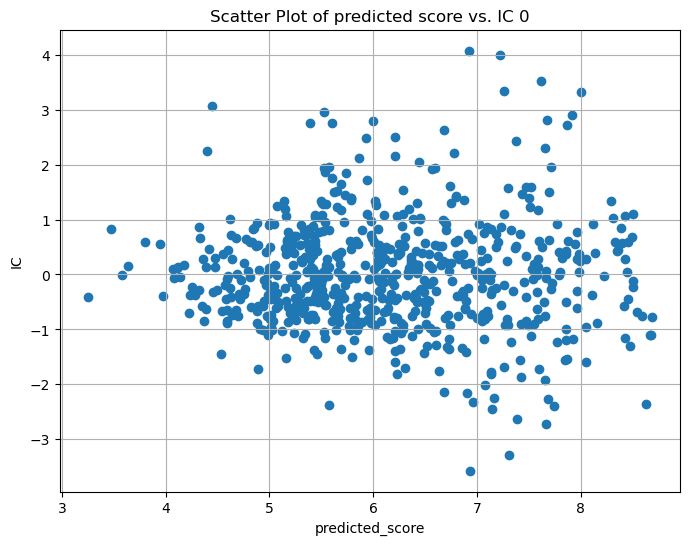

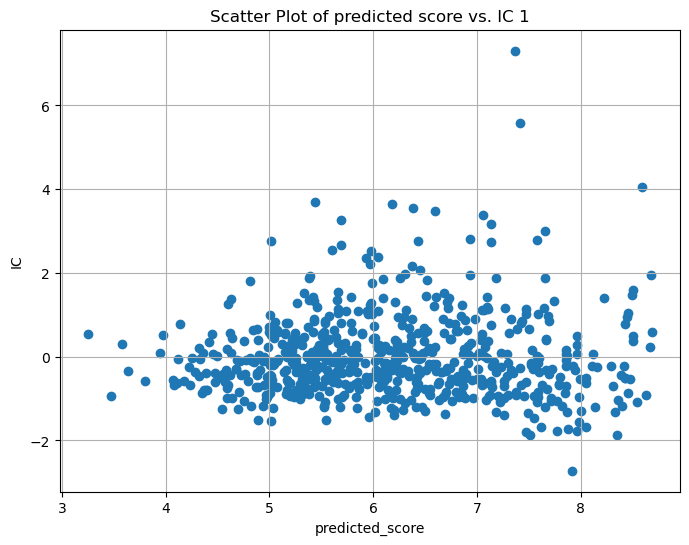

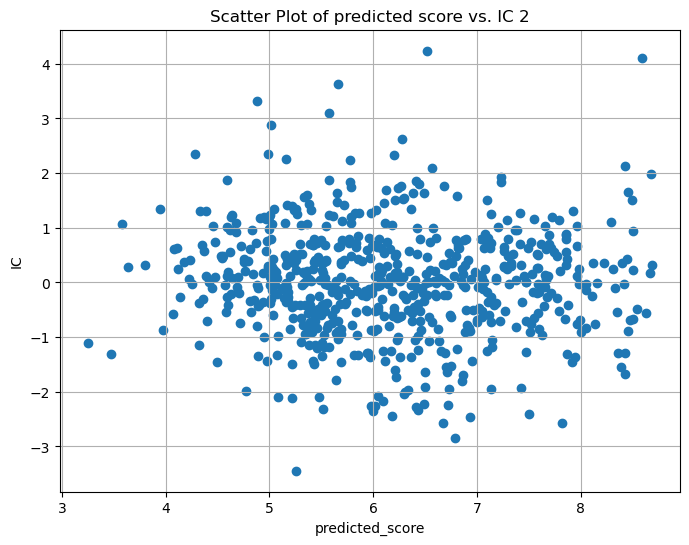

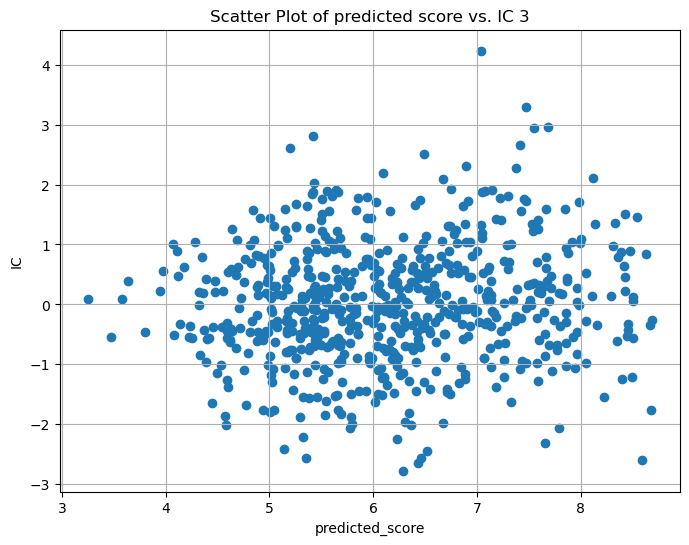

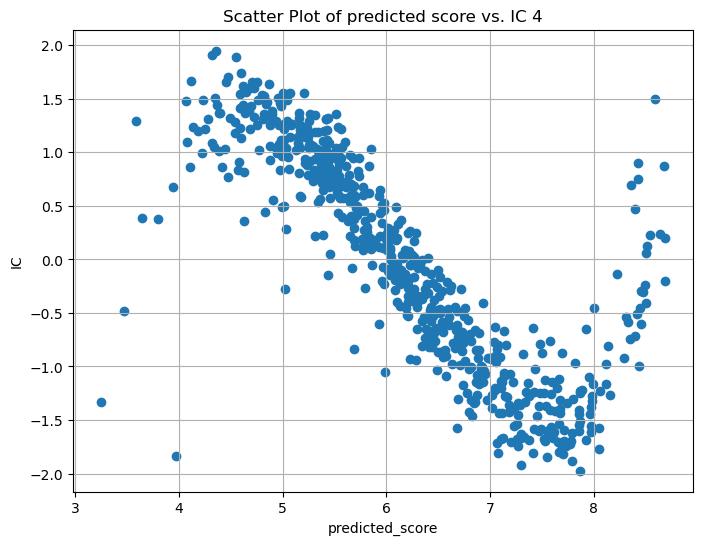

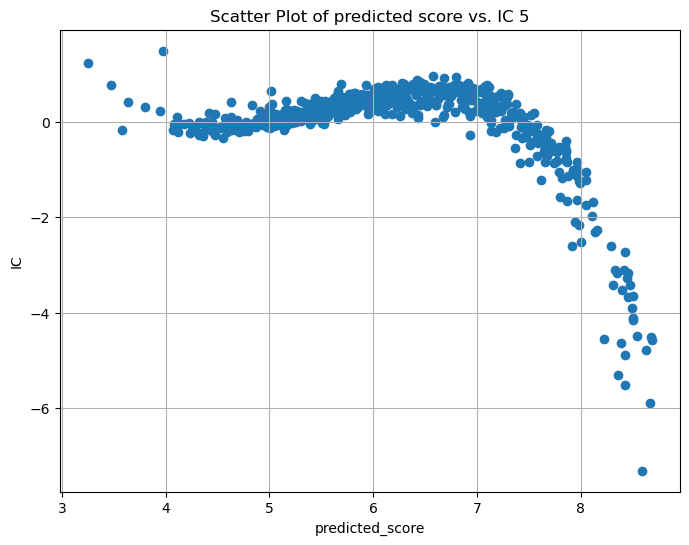

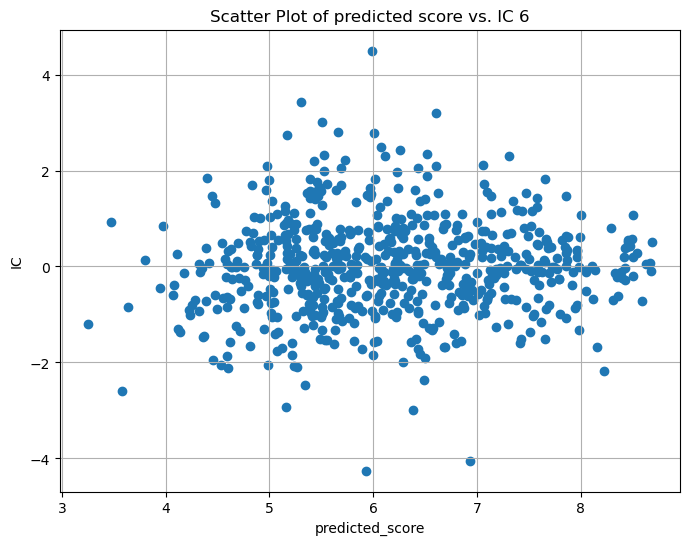

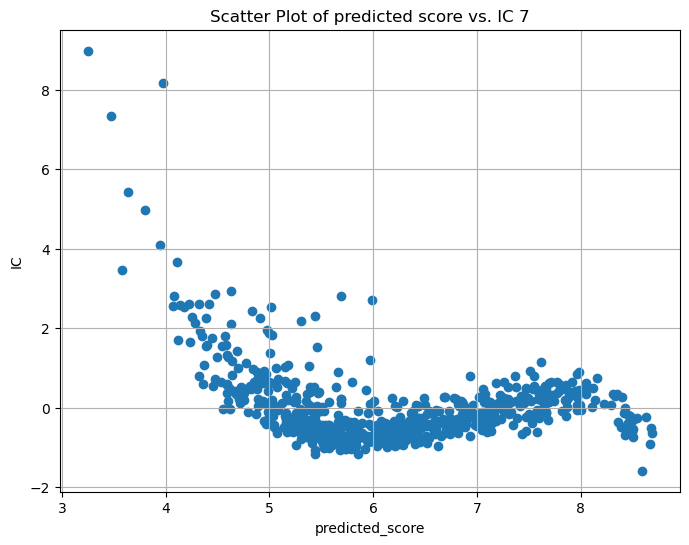

In [48]:
for ic in range(0,8):
    # Create a scatter plot using matplotlib
    plt.figure(figsize=(8, 6)) # Optional: Set the figure size
    plt.scatter(essay_IC['predicted_score'], essay_IC[f'IC_{ic}'])
    
    # Add labels and title
    plt.xlabel('predicted_score')
    plt.ylabel('IC')
    plt.title(f'Scatter Plot of predicted score vs. IC {ic}')
    
    # Optional: Add a grid
    plt.grid(True)
    
    # Show the plot
    plt.show()

### Decision tree as a surrogate model to explore components path to predicted scores

#### Layer 1-12

In [ ]:
### Decision Tree model on Functional Components of each layer to predict predicted scores
### Examine R2 explained by FCs of each layer

In [15]:
test_pred_pd_cp = test_pred_pd.copy()

In [37]:
### Layer 12 CLS Functional Components predicting predicted scores
# extract the cls_activations shape = (batch, embedding_size)
for layer_idx in range(1,13,1):
    print("*"*60)
    print(f'Current Layer: {layer_idx}')
    print("*"*60)
    
    cls_activations_test = extract_cls_activations_batched(test_pred_pd_cp['full_text'].values, model, tokenizer, batch_size = 8, layer_idx = layer_idx)
    
    # number of components to extract (95% variance) using PCA
    pca = PCA(n_components=0.95)
    pca.fit(cls_activations_test)
    n_components = pca.n_components_
    
    print(f"\nNumber of components for 95% variance: {n_components}")
    
    # APPLY ICA
    ica = FastICA(n_components=n_components, random_state=42)
    
    # fit ICA and transform CLS activations to component scores
    S = ica.fit_transform(cls_activations_test)  # shape: (batch_size, n_components)
    
    # convert S to a dataframe - each row represent the original essay seq
    component_cols = [f"IC_{i}" for i in range(n_components)]
    component_df = pd.DataFrame(S, columns=component_cols)
    
    # Join functional components with validation essays - align functional components with rubric scores
    essay_IC = pd.concat([test_pred_pd_cp.reset_index(drop=True), component_df], axis=1)

    # Regression Tree
    X = essay_IC[essay_IC.columns.to_list()[12:]]
    y = essay_IC["predicted_score"]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        y, 
                                                        test_size=0.2, 
                                                        random_state=42)

    # Train
    tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
    tree_model.fit(X_train, y_train)
    
    # Feature importance
    feature_importance = pd.Series(tree_model.feature_importances_, index=X.columns)
    feature_importance = feature_importance[feature_importance > 0].sort_values(ascending=False)
    
    # prediction
    y_pred = tree_model.predict(X_test)
    
    # regression eval
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    
    rmse = np.sqrt(mse) 
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    
    r2 = r2_score(y_test, y_pred)
    print(f"R-squared (R2): {r2:.4f}")

************************************************************
Current Layer: 1
************************************************************

Number of components for 95% variance: 92
Mean Absolute Error (MAE): 0.9468
Mean Squared Error (MSE): 1.3456
Root Mean Squared Error (RMSE): 1.1600
R-squared (R2): -0.0715
************************************************************
Current Layer: 2
************************************************************

Number of components for 95% variance: 89
Mean Absolute Error (MAE): 0.9302
Mean Squared Error (MSE): 1.2837
Root Mean Squared Error (RMSE): 1.1330
R-squared (R2): -0.0222
************************************************************
Current Layer: 3
************************************************************

Number of components for 95% variance: 111
Mean Absolute Error (MAE): 0.9427
Mean Squared Error (MSE): 1.2555
Root Mean Squared Error (RMSE): 1.1205
R-squared (R2): 0.0003
************************************************************
Cur

#### Pooled Layer

In [40]:
# Regression Tree
X = essay_IC[essay_IC.columns.to_list()[12:]]
y = essay_IC["predicted_score"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

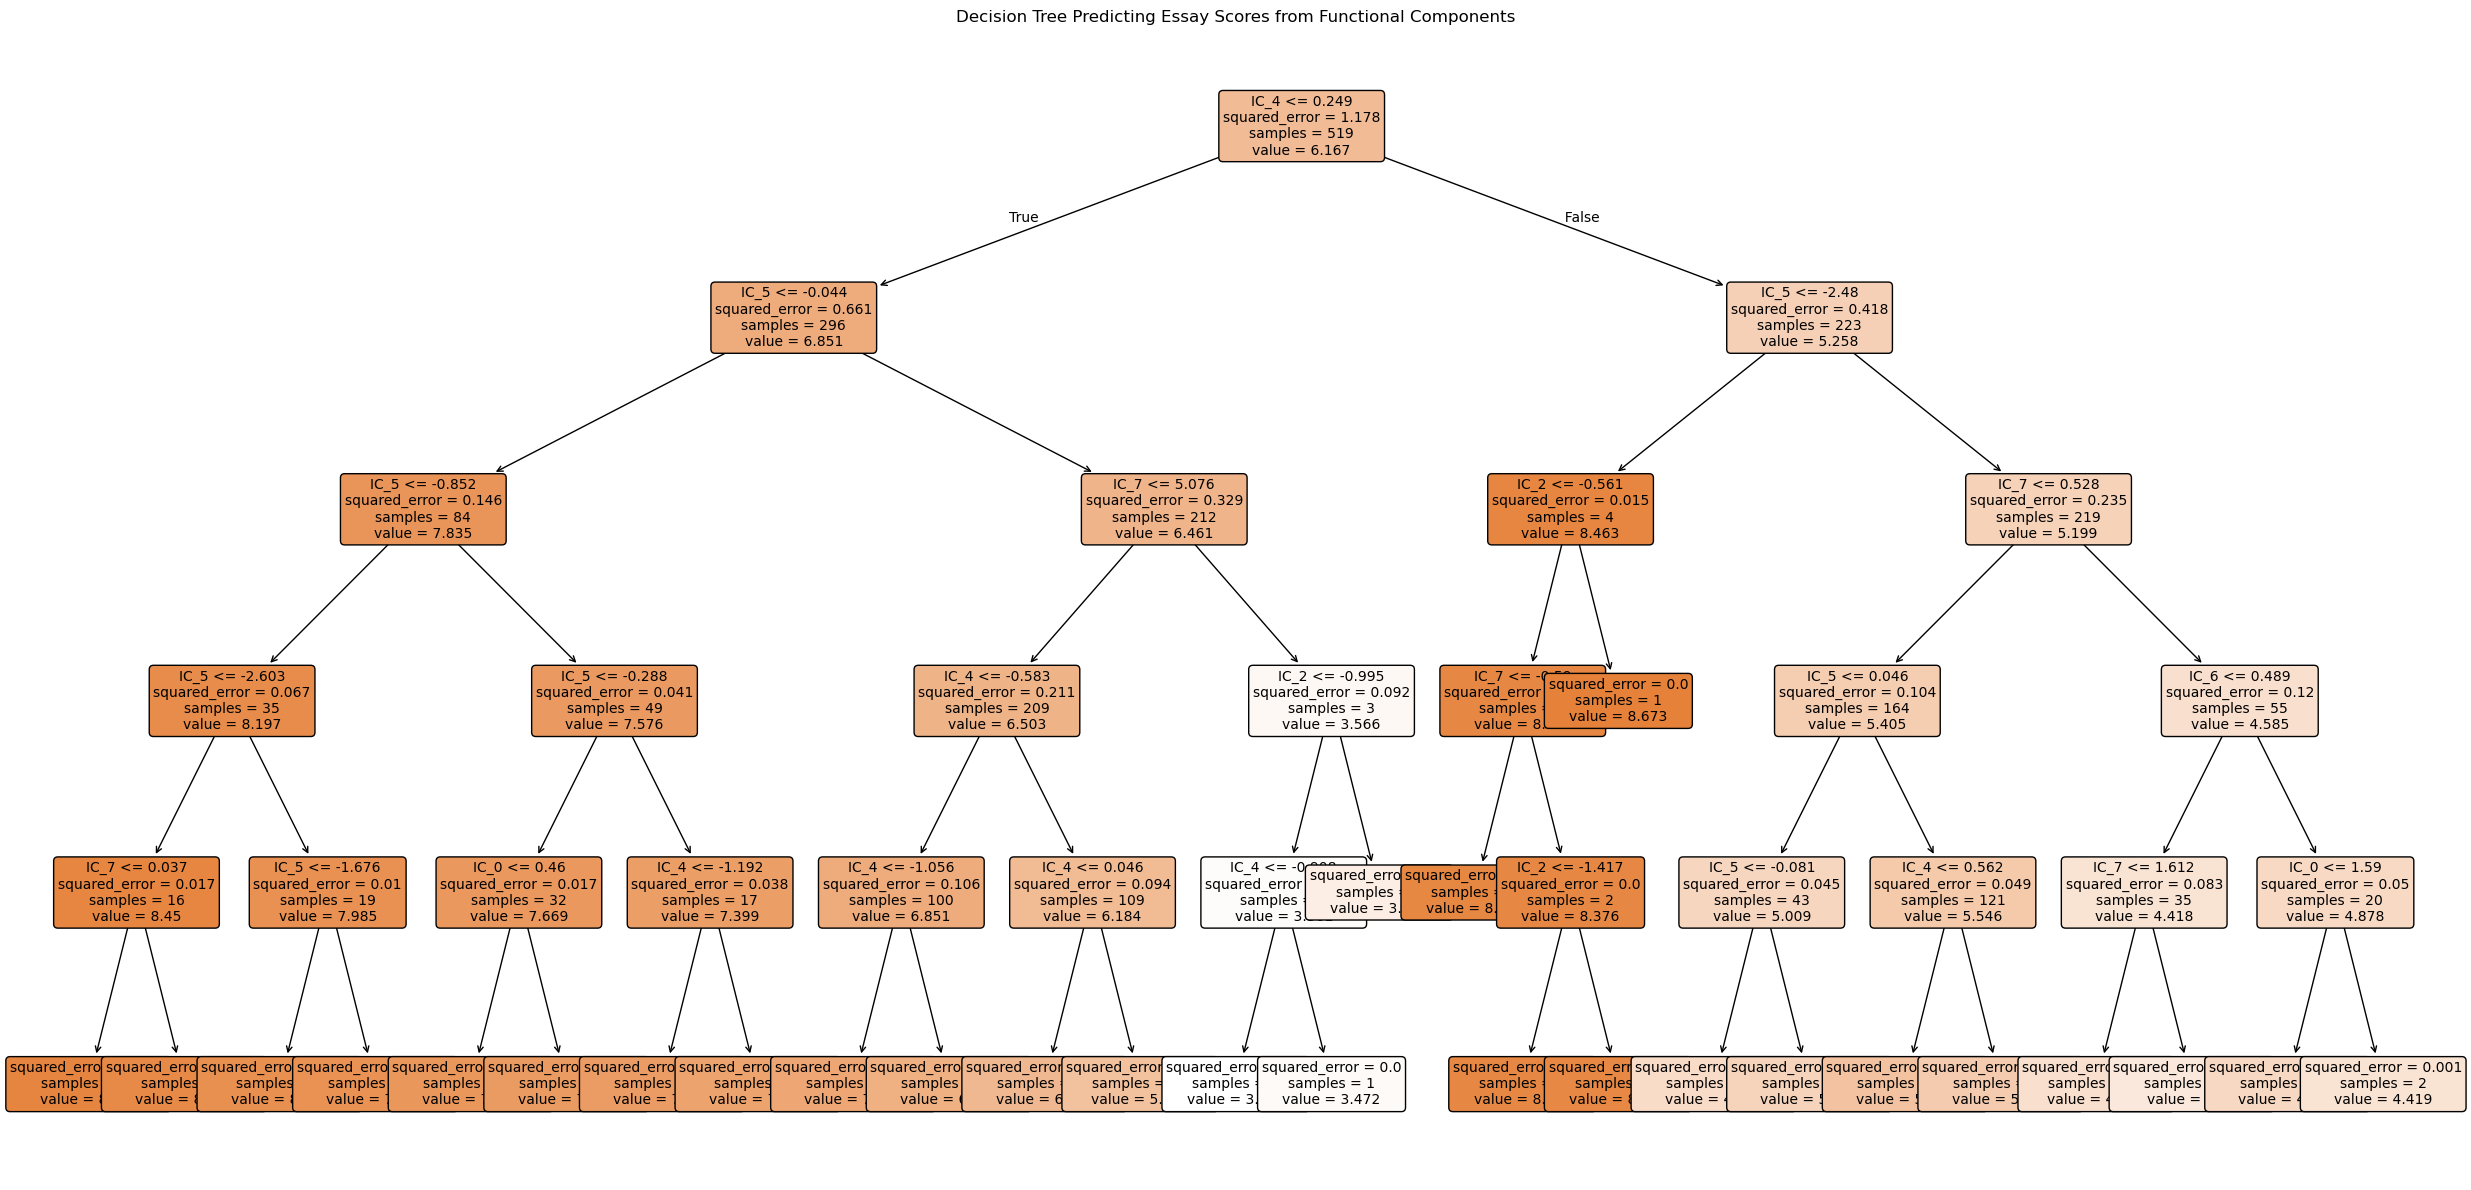

IC_4    0.603146
IC_5    0.298142
IC_7    0.092531
IC_6    0.004569
IC_0    0.001085
IC_2    0.000527
dtype: float64

In [45]:
# Train
tree_model = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)

# Plot tree
plt.figure(figsize=(25, 12))
plot_tree(tree_model, feature_names=X.columns, filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree Predicting Essay Scores from Functional Components")
plt.tight_layout()

# saving
plt.savefig("decision_tree_essay_scores_reg.png") 
plt.show()

# Feature importance
feature_importance = pd.Series(tree_model.feature_importances_, index=X.columns)
feature_importance = feature_importance[feature_importance > 0].sort_values(ascending=False)
feature_importance.head(10)

In [46]:
# prediction
y_pred = tree_model.predict(X_test)

# regression eval
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.4f}")

rmse = np.sqrt(mse) 
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

r2 = r2_score(y_test, y_pred)
print(f"R-squared (R2): {r2:.4f}")

Mean Absolute Error (MAE): 0.2155
Mean Squared Error (MSE): 0.0747
Root Mean Squared Error (RMSE): 0.2734
R-squared (R2): 0.9405
